In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from matplotlib import mlab
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from inceptionresnetv2 import inceptionresnetv2
import torchvision.transforms as transforms

In [3]:
class LOCNet(nn.Module):
    def __init__(self):
        super(LOCNet, self).__init__()
        self.features =  nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.Dropout()
            # Flatten()
        )
        self.linear = nn.Linear(5184, 6)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x.view(-1, 2, 3)

In [4]:
class TransClf(nn.Module):
    def __init__(self, num_classes=100):
        super(TransClf, self).__init__()
        self.loc_net = LOCNet()
        self.features = inceptionresnetv2(num_classes=num_classes)
    def forward(self, x):
        out = self.loc_net(x)
        grid = F.affine_grid(out, x.size())
        loc = F.grid_sample(x, grid)
        out = self.features(loc)
        return loc, out
        

In [5]:
stn_clf = TransClf(num_classes=99891)

In [6]:
ckpt_path = 'ckpts/checkpoint.t7'

In [7]:
states = torch.load(ckpt_path)

In [8]:
stn_clf = nn.DataParallel(stn_clf).cuda()

In [9]:
stn_clf.load_state_dict(states)

In [10]:
trans = transforms.Compose([transforms.Scale((160, 160)), transforms.ToTensor()])

In [36]:
def inf_image(path):
    img = Image.open(path).convert('RGB')
    input_img = trans(img)
    inputs = input_img.unsqueeze(0)
    loc, out = stn_clf(Variable(inputs))
    location = loc.data.cpu().numpy()
    plt.imshow(location.squeeze(0).transpose(1,2,0))

In [11]:
img = Image.open('/data/wenfahu/1vn_train/000E66B7BF84234E84C1F698F454571B/000E66B7BF84234E84C1F698F454571B_0001.png')

In [28]:
img = Image.open('/data/decode_MsCeleb1M/m.03m462/0-FaceId-0.png')

In [29]:
img = img.convert('RGB')

In [30]:
input_img = trans(img)

In [31]:
inputs = input_img.unsqueeze(0)

In [32]:
from torch.autograd import Variable

In [33]:
loc, out = stn_clf(Variable(inputs))

In [34]:
location = loc.data.cpu().numpy()

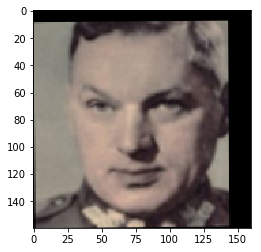

In [35]:
plt.imshow(location.squeeze(0).transpose(1,2,0))

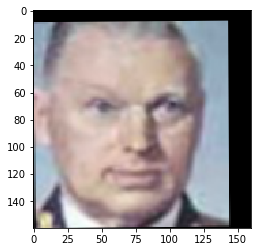

In [37]:
inf_image('/data/decode_MsCeleb1M/m.03m462/10-FaceId-0.png')

In [39]:
from scipy import misc

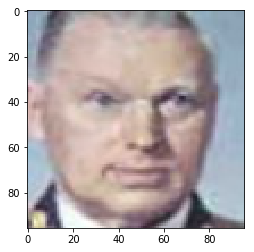

In [40]:
plt.imshow(misc.imread('/data/decode_MsCeleb1M/m.03m462/10-FaceId-0.png'))